# D3D Helper

Unofficial example code for using a pre-trained Distilled 3D Network (D3D) for video classification. For more details, please refer to the paper:

"D3D: Distilled 3D Networks for Video Action Recognition."  
_Jonathan C. Stroud, David A. Ross, Chen Sun, Jia Deng, and Rahul Sukthankar._  
[arXiv 2018](https://arxiv.org/abs/1812.08249)

## Prerequisites

1. Tensorflow 1.12
2. imageio
3. skimage
2. Place model checkpoints from [Google Drive](https://drive.google.com/drive/folders/1Yb-g-Ae_B4tyM7N7bk0kRd2r5ChO-oa3?usp=sharing) and place them in `d3dhelper/weights`.

In [1]:
import sys
import imageio
import numpy as np
import skimage.transform
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('./models/research/slim')
from nets import i3d
from nets import s3dg
arg_scope = tf.contrib.framework.arg_scope

# Model options
_NET_TYPE = 's3dg'  # Options: 's3dg', 'i3d'
_DATASET = 'kinetics_400'  # Options: 'kinetics_400', 'kinetics_600'
_MODEL_CKPT = './weights/d3d_kinetics_400/model.ckpt'

# Video options
_INPUT_SIZE = 224
_NUM_FRAMES = 64

## Initialize model architecture

In [2]:
inputs = tf.placeholder(tf.float32, (1, 64, 224, 224, 3))

if _DATASET == 'kinetics_400':
    num_classes = 400
elif _DATASET == 'kinetics_600':
    num_classes = 600

if _NET_TYPE == 's3dg':
    sc = s3dg.s3dg_arg_scope()
    with arg_scope(sc):
        net, end_points = s3dg.s3dg(inputs, num_classes, is_training=False)
elif _NET_TYPE == 'i3d':
    sc = i3d.i3d_arg_scope()
    with arg_scope(sc):
        net, end_points = i3d.i3d(inputs, num_classes, is_training=False)
else:
    print('Network type not supported.')

## Load sample videos

In [3]:
def load_video(fn):

    video = np.ndarray((1, _NUM_FRAMES, _INPUT_SIZE, _INPUT_SIZE, 3), np.float32)
    reader = imageio.get_reader(fn)

    for i, im in zip(range(_NUM_FRAMES), reader):
        # Convert to float
        im = im / 255
        # Scale
        h, w = im.shape[:2]
        min_side = min(h, w)
        scale_factor = _INPUT_SIZE/min_side
        im = skimage.transform.resize(im, (int(h*scale_factor), int(w*scale_factor)))
        # Center crop
        h, w = im.shape[:2]
        im = im[(h-_INPUT_SIZE)//2:(h+_INPUT_SIZE)//2,
                (w-_INPUT_SIZE)//2:(w+_INPUT_SIZE)//2]
        video[:, i] = im
        
    return video

In [4]:
abseiling = load_video('abseiling.mp4')
airdrum = load_video('airdrum.mp4')

In [5]:
def show_video(video):
    plt.subplot(1, 3, 1)
    plt.imshow(video[:, _NUM_FRAMES//4].squeeze())
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(video[:, _NUM_FRAMES//2].squeeze())
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(video[:, 3*_NUM_FRAMES//4].squeeze())
    plt.axis('off')
    plt.show()

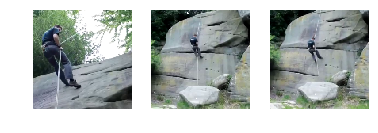

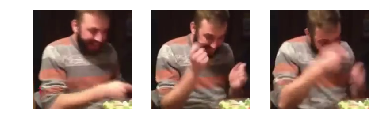

In [6]:
show_video(abseiling)
show_video(airdrum)

## Load D3D weights and run model

In [7]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, _MODEL_CKPT)
    
    net_eval_abseiling = sess.run(net, feed_dict={inputs: abseiling})
    net_eval_airdrum = sess.run(net, feed_dict={inputs: airdrum})

INFO:tensorflow:Restoring parameters from ./weights/d3d_kinetics_400/model.ckpt


## Check results

"abseiling" and "air drumming" are classes 0 and 1 in Kinetics-400, respectively.

In [8]:
print(net_eval_abseiling.argmax())

0


In [9]:
print(net_eval_airdrum.argmax())

1
